In [1]:
# Manipulation de données
import pandas as pd
import numpy as np

# Traitement de texte & NLP
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Modèles de transformation de texte
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec

# Prétraitement & Normalisation
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

# Réduction de dimensionnalité
from sklearn.manifold import TSNE

# Deep Learning avec TensorFlow
import tensorflow as tf

# Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Distance de Wasserstein
from scipy.stats import wasserstein_distance

# Chargement du modèle SpaCy et configuration Pandas
nlp = spacy.load("en_core_web_sm")
pd.set_option('display.max_colwidth', None)

# Chargement du modèle de phrase embedding
model = SentenceTransformer('all-MiniLM-L6-v2')


c:\Users\raymo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# chargement des données avec SBERT embeddings
df_sbert = pd.read_pickle("df_sbert.pkl")

In [3]:
df_sbert['embedding'][0].shape

(384,)

In [ ]:
#embeddings = np.array(df_sbert['embedding'].tolist())  # Convert column to NumPy array
#labels = df_sbert['label'].tolist()  # Retrieve class labels

In [ ]:
# permet de calculer la distance de Wasserstein pour voir si elle baisse à chaque itération
def compute_average_wasserstein(real_data, synthetic_data):
    """
    Calcule la distance de Wasserstein pour chaque dimension et renvoie la moyenne.
    real_data et synthetic_data doivent être de forme (n_samples, embedding_dim).
    """
    dims = real_data.shape[1]
    wd_values = []
    for d in range(dims):
        wd = wasserstein_distance(real_data[:, d], synthetic_data[:, d])
        wd_values.append(wd)
    avg_wd = np.mean(wd_values)
    return avg_wd, wd_values

In [ ]:
# Import pour le GAN

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import disable_interactive_logging
from tensorflow.keras.layers import Reshape
from sklearn.preprocessing import StandardScaler

In [7]:
# Test le GAN d'abord UNIQUEMENT sur les données de racisme

# Prepare embeddings for 'racism' cases and scale them
racism_embeddings = np.vstack(df_sbert[df_sbert['label'] == 'racism']['embedding'].values)

scaler = StandardScaler()
racism_embeddings_scaled = scaler.fit_transform(racism_embeddings)

# Use scaled embeddings and add an extra dimension for GAN input compatibility
train_embeddings = np.expand_dims(racism_embeddings_scaled, axis=1)  # Shape: (num_samples, 1, embedding_dim)

In [18]:
train_embeddings.shape

(1970, 1, 384)

In [ ]:
# Architecture LSTM à priori meilleure pour les phrases
def build_generator(input_dim, output_dim, seq_length=1):
    model = Sequential([
        LSTM(128, input_shape=(seq_length, input_dim), return_sequences=True),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        Dropout(0.2),

        LSTM(256, return_sequences=True),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        Dropout(0.2),

        LSTM(384, return_sequences=False),
        LeakyReLU(alpha=0.2)

        #Dense(output_dim, activation='tanh')  # Normalisation dans [-1,1]
    ])
    return model


In [19]:
def build_discriminator(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        BatchNormalization(),
        Dense(64),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        BatchNormalization(),
        Dense(1, activation='sigmoid')  # classification binaire
    ])
    return model

In [20]:
# ====== HYPERPARAMÈTRES ======
embedding_dim = racism_embeddings_scaled.shape[1]  # e.g., 384 (SBERT output size)
noise_dim = 100  # Dimension du vecteur bruit pour le générateur
batch_size = 64
epochs = 10000

# ====== INITIALISATION DES MODÈLES ======
generator = build_generator(noise_dim, embedding_dim)
discriminator = build_discriminator(embedding_dim)

# Compilation du discriminateur (entraînement séparé du générateur)
discriminator.compile(
    optimizer=Adam(0.0002, 0.5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Construction du GAN (discriminateur gelé pour l'entraînement du générateur)
discriminator.trainable = False
gan_input = Input(shape=(1, noise_dim))  # LSTM attend une entrée 3D
generated_embedding = generator(gan_input)
gan_output = discriminator(generated_embedding)
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss="binary_crossentropy")


# ====== FONCTION D'ENTRAÎNEMENT ======
def train_gan(generator, discriminator, gan, real_embeddings, epochs, batch_size):
    
    real_labels = np.ones((batch_size, 1)) * 0.9  # Label smoothing pour stabiliser l'entraînement
    fake_labels = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ----- 1. ENTRAÎNEMENT DU DISCRIMINATEUR -----
        discriminator.trainable = True

        # Sélection d'un batch d'exemples réels
        idx = np.random.randint(0, real_embeddings.shape[0], batch_size)
        real_samples = np.squeeze(real_embeddings[idx], axis=1)  # Suppression de la 2e dimension inutile

        # Génération d'un batch de faux exemples
        noise = np.random.normal(0, 1, (batch_size, 1, noise_dim))
        fake_samples = generator.predict(noise, verbose=0)

        # Entraînement du discriminateur sur réels et faux
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ----- 2. ENTRAÎNEMENT DU GÉNÉRATEUR (via le GAN) -----
        discriminator.trainable = False  # On empêche D d’être mis à jour
        noise = np.random.normal(0, 1, (batch_size, 1, noise_dim))
        g_loss = gan.train_on_batch(noise, real_labels)  # On veut que G trompe D

        # ----- 3. AFFICHAGE DES MÉTRIQUES TOUS LES 500 EPOCHS -----
        if epoch % 500 == 0:
            # Génération d'un batch de faux exemples pour l'évaluation
            noise_eval = np.random.normal(0, 1, (batch_size, 1, noise_dim))
            synthetic_samples = generator.predict(noise_eval, verbose=0)

            # Sélection d'un batch réel pour la comparaison
            idx_eval = np.random.randint(0, real_embeddings.shape[0], batch_size)
            real_samples_eval = np.squeeze(real_embeddings[idx_eval], axis=1)

            # Calcul de la distance de Wasserstein
            avg_wd, wd_values = compute_average_wasserstein(real_samples_eval, synthetic_samples)

            print(f"Epoch {epoch} | D Loss: {d_loss[0]:.4f} | G Loss: {g_loss:.4f} | Avg WD: {avg_wd:.4f}")


# ====== LANCEMENT DE L'ENTRAÎNEMENT ======
train_gan(generator, discriminator, gan, train_embeddings, epochs, batch_size)

c:\Users\raymo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\raymo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\raymo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0 | D Loss: 0.8844 | G Loss: 0.6579 | Avg WD: 0.7947
Epoch 500 | D Loss: 0.7509 | G Loss: 0.6266 | Avg WD: 0.7236
Epoch 1000 | D Loss: 0.7268 | G Loss: 0.6342 | Avg WD: 0.6651
Epoch 1500 | D Loss: 0.7156 | G Loss: 0.6465 | Avg WD: 0.6695
Epoch 2000 | D Loss: 0.7094 | G Loss: 0.6586 | Avg WD: 0.6901
Epoch 2500 | D Loss: 0.7056 | G Loss: 0.6683 | Avg WD: 0.6875
Epoch 3000 | D Loss: 0.7029 | G Loss: 0.6760 | Avg WD: 0.7016
Epoch 3500 | D Loss: 0.7010 | G Loss: 0.6825 | Avg WD: 0.7043
Epoch 4000 | D Loss: 0.6995 | G Loss: 0.6882 | Avg WD: 0.7012
Epoch 4500 | D Loss: 0.6983 | G Loss: 0.6933 | Avg WD: 0.7095
Epoch 5000 | D Loss: 0.6973 | G Loss: 0.6983 | Avg WD: 0.7171
Epoch 5500 | D Loss: 0.6965 | G Loss: 0.7030 | Avg WD: 0.7053
Epoch 6000 | D Loss: 0.6959 | G Loss: 0.7073 | Avg WD: 0.7090
Epoch 6500 | D Loss: 0.6953 | G Loss: 0.7114 | Avg WD: 0.7326
Epoch 7000 | D Loss: 0.6948 | G Loss: 0.7151 | Avg WD: 0.7393
Epoch 7500 | D Loss: 0.6944 | G Loss: 0.7186 | Avg WD: 0.7190
Epoch 8000 |

In [21]:
# Génération d'embeddings synthétiques

def generate_synthetic_embeddings(generator, noise_dim, num_samples=10):
    noise = np.random.normal(0, 1, (num_samples, 1, noise_dim))  # Ajout de la dimension pour le LSTM
    synthetic_embeddings = generator.predict(noise, verbose=0)
    return synthetic_embeddings

# Chargement des embeddings réels
real_embeddings = np.array([np.array(embed)[:384] for embed in racism_embeddings])


# Génération des embeddings synthétiques
synthetic_embeddings = generate_synthetic_embeddings(generator, noise_dim, num_samples=2000)

print(f"Real embeddings shape: {real_embeddings.shape}")
print(f"Synthetic embeddings shape: {synthetic_embeddings.shape}")

Real embeddings shape: (1970, 384)
Synthetic embeddings shape: (2000, 384)


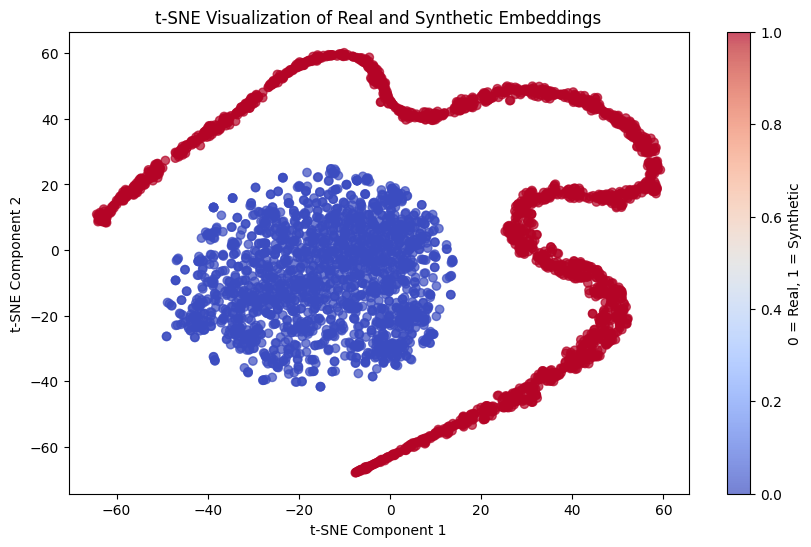

In [22]:
# Concaténation pour la visualisation
all_embeddings = np.vstack((real_embeddings, synthetic_embeddings))
labels = np.array([0] * len(real_embeddings) + [1] * len(synthetic_embeddings))

# Normalisation avant t-SNE (évite les problèmes d'échelle)
scaler = StandardScaler()
all_embeddings_scaled = scaler.fit_transform(all_embeddings)

# Application de t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings_scaled)

# Affichage des résultats
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(label="0 = Real, 1 = Synthetic")
plt.title("t-SNE Visualization of Real and Synthetic Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


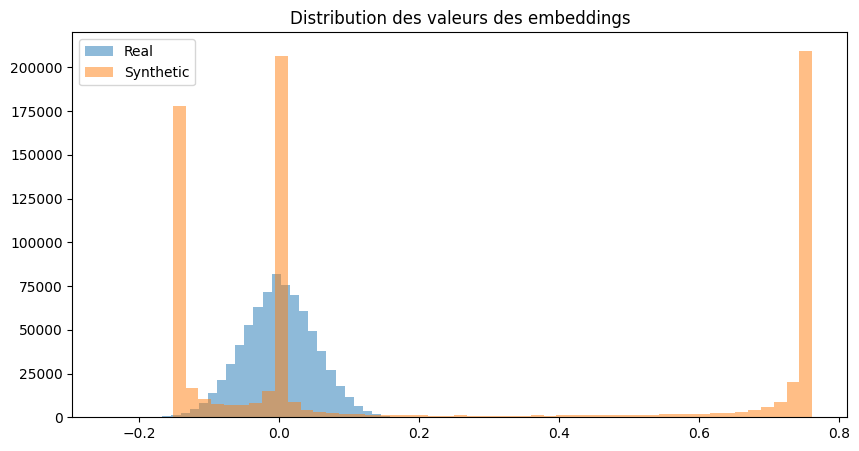

In [23]:
plt.figure(figsize=(10,5))
plt.hist(real_embeddings.flatten(), bins=50, alpha=0.5, label="Real")
plt.hist(synthetic_embeddings.flatten(), bins=50, alpha=0.5, label="Synthetic")
plt.legend()
plt.title("Distribution des valeurs des embeddings")
plt.show()

In [15]:
avg_wd, wd_values = compute_average_wasserstein(racism_embeddings_scaled, synthetic_embeddings)
print("Distance de Wasserstein moyenne :", avg_wd)

Distance de Wasserstein moyenne : 0.7050530045738368
